In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

/home/meysam/anaconda3/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text))


In [4]:
import numpyro
import numpyro.distributions as dist

import jax
from jax import random

import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on theano: v1.0.4
Running on PYMC3: v3.8


In [8]:
print('Running on numpyro: v{}'.format(numpyro.__version__))
print('Running on jax: v{}'.format(jax.__version__))


Running on numpyro: v0.3.0
Running on jax: v0.1.73


# Data

In [9]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

# PyMC3

## Centered_eight

In [10]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    #eta = pm.Normal('eta', 0, 1, shape=J)
    #theta = pm.Deterministic('theta', mu + tau*eta)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)

In [11]:
with Centered_eight:
    trace_cen = pm.sample(draws=2000, tune=2000, chains=4, target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]
Sampling 4 chains, 31 divergences: 100%|██████████| 16000/16000 [02:20<00:00, 114.02draws/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9556114776293788, but should be close to 0.99. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.948763743149548, but should be close to 0.99. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
pm.summary(trace_cen).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,4.40,3.39,-2.26,10.59,0.11,0.08,1025.0,1025.0,1035.0,1221.0,1.00
theta[0],6.40,5.76,-4.38,17.39,0.16,0.11,1276.0,1276.0,1220.0,1516.0,1.00
theta[1],4.98,4.81,-4.35,13.86,0.12,0.09,1744.0,1539.0,1648.0,1769.0,1.00
theta[2],3.87,5.45,-6.20,14.53,0.13,0.09,1795.0,1795.0,1625.0,2459.0,1.00
theta[3],4.73,4.90,-4.30,14.35,0.11,0.08,1864.0,1864.0,1741.0,2002.0,1.00
theta[4],3.51,4.90,-5.68,12.72,0.12,0.09,1566.0,1566.0,1503.0,2168.0,1.00
theta[5],4.05,5.07,-5.77,13.46,0.12,0.08,1831.0,1831.0,1701.0,2234.0,1.00
theta[6],6.49,5.29,-2.97,17.29,0.16,0.11,1151.0,1151.0,1089.0,1296.0,1.00
theta[7],4.92,5.71,-5.62,16.09,0.12,0.10,2110.0,1815.0,1821.0,1946.0,1.00
tau,3.84,3.37,0.07,9.80,0.20,0.14,269.0,269.0,173.0,335.0,1.01


In [13]:
# display the total number and percentage of divergent
divergent = trace_cen['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace_cen) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 31
Percentage of Divergent 1.6


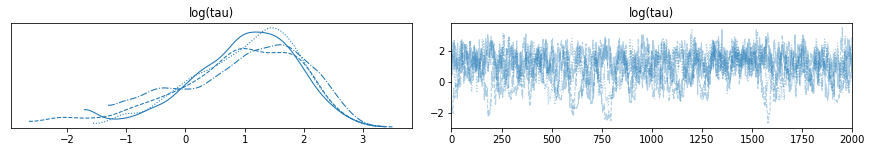

In [14]:
# plot the trace of log(tau)
pm.traceplot({"log(tau)": trace_cen.get_values(varname='tau_log__', combine=False)});
plt.show()

In [15]:
def pairplot_divergence(trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    theta = trace.get_values(varname='theta', combine=True)[:, 0]
    logtau = trace.get_values(varname='tau_log__', combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel('theta[0]')
    ax.set_ylabel('log(tau)')
    ax.set_title('scatter plot between log(tau) and theta[0]');
    return ax

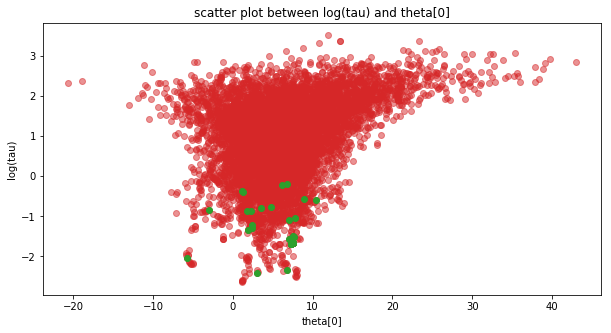

In [16]:
pairplot_divergence(trace_cen)
plt.show();

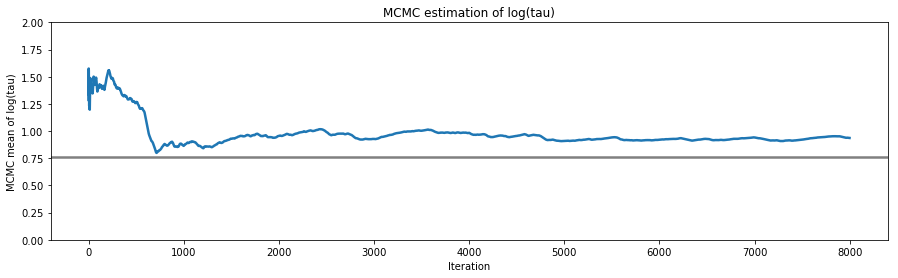

In [17]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(trace_cen['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');
plt.show()

## NonCentered_eight

In [18]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_tilde', mu=0, sigma=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)

In [19]:
with NonCentered_eight:
    trace_noncen = pm.sample(draws=2000, tune=2000, chains=4, target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_tilde, tau, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:25<00:00, 618.41draws/s]


In [20]:
pm.summary(trace_noncen).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,4.36,3.30,-1.62,10.73,0.04,0.03,6276.0,6093.0,6297.0,5314.0,1.0
theta_tilde[0],0.33,0.99,-1.55,2.14,0.01,0.01,7203.0,4770.0,7203.0,6092.0,1.0
theta_tilde[1],0.12,0.93,-1.61,1.86,0.01,0.01,7794.0,3622.0,7814.0,5862.0,1.0
theta_tilde[2],-0.09,0.97,-1.92,1.70,0.01,0.01,8282.0,3367.0,8259.0,5447.0,1.0
theta_tilde[3],0.07,0.96,-1.70,1.84,0.01,0.01,7991.0,4127.0,7998.0,6074.0,1.0
theta_tilde[4],-0.15,0.94,-1.90,1.65,0.01,0.01,6453.0,3855.0,6435.0,5162.0,1.0
theta_tilde[5],-0.08,0.93,-1.70,1.83,0.01,0.01,7234.0,3814.0,7241.0,5591.0,1.0
theta_tilde[6],0.35,0.97,-1.40,2.25,0.01,0.01,6649.0,4973.0,6730.0,5721.0,1.0
theta_tilde[7],0.06,0.99,-1.92,1.82,0.01,0.01,7514.0,4157.0,7513.0,5434.0,1.0
tau,3.61,3.20,0.00,9.33,0.04,0.03,5311.0,5311.0,4164.0,3305.0,1.0


In [21]:
# display the total number and percentage of divergent
divergent = trace_noncen['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace_noncen) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


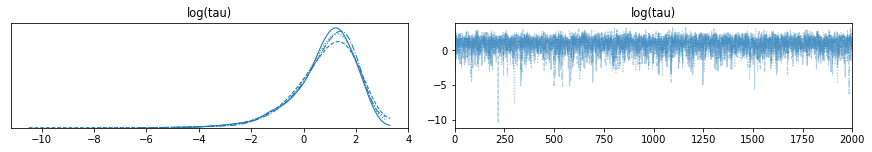

In [22]:
# plot the trace of log(tau)
pm.traceplot({"log(tau)": trace_noncen.get_values(varname='tau_log__', combine=False)});
plt.show()

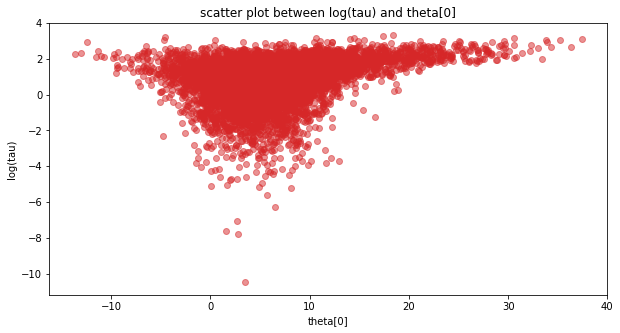

In [23]:
pairplot_divergence(trace_noncen)
plt.show();

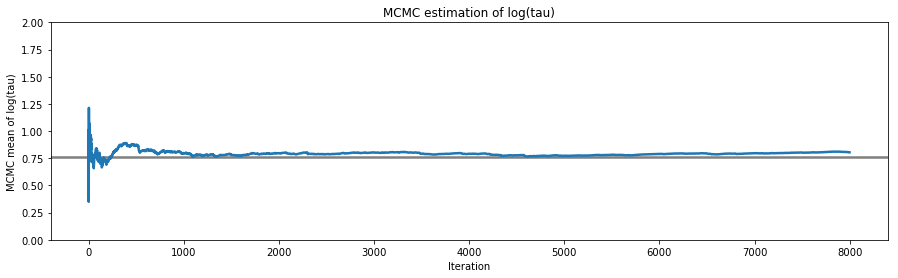

In [24]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(trace_noncen['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');
plt.show()

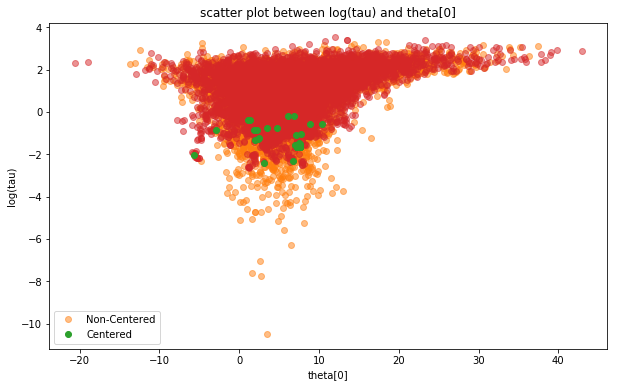

In [25]:

_, ax = plt.subplots(1, 1, figsize=(10, 6))

pairplot_divergence(trace_noncen, ax=ax, color='C1', divergence=True)
pairplot_divergence(trace_cen, ax=ax, color='C3', divergence=True)

ax.legend(['Non-Centered', 'Centered'])
plt.show()

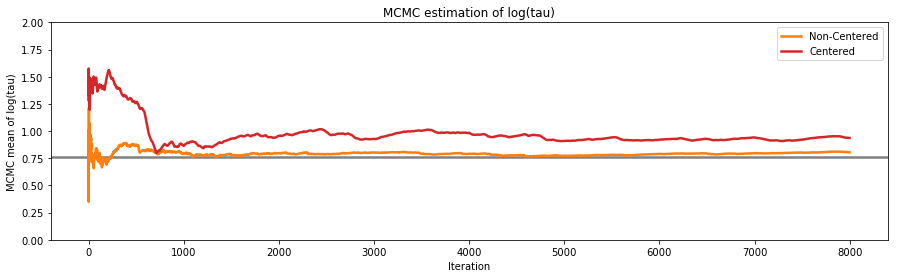

In [26]:
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')


logtau_noncen = np.log(trace_noncen['tau'])
mlogtau_noncen = [np.mean(logtau_noncen[:i]) for i in np.arange(1, len(logtau_noncen))]
plt.plot(mlogtau_noncen, color='C1', lw=2.5, label='Non-Centered')

logtau_cen = np.log(trace_cen['tau'])
mlogtau_cen = [np.mean(logtau_cen[:i]) for i in np.arange(1, len(logtau_cen))]

plt.plot(mlogtau_cen, color='C3', lw=2.5, label='Centered')


plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();
plt.show()

In [27]:
waic_cen = pm.waic(trace_cen, Centered_eight)
waic_cen

Computed from 8000 by 8 log-likelihood matrix

          Estimate       SE
elpd_waic   -30.72     1.34
p_waic        0.88        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [28]:
loo_cen = pm.waic(trace_cen, Centered_eight)
loo_cen

Computed from 8000 by 8 log-likelihood matrix

          Estimate       SE
elpd_waic   -30.72     1.34
p_waic        0.88        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [29]:
waic_noncen = pm.waic(trace_noncen, NonCentered_eight)
waic_cen

Computed from 8000 by 8 log-likelihood matrix

          Estimate       SE
elpd_waic   -30.72     1.34
p_waic        0.88        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [30]:
loo_noncen = pm.loo(trace_noncen, NonCentered_eight)
loo_noncen

Computed from 8000 by 8 log-likelihood matrix

         Estimate       SE
elpd_loo   -30.70     1.36
p_loo        0.86        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5   62.5%
 (0.5, 0.7]   (ok)          3   37.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [31]:
NonCentered_eight.name = 'NonCentered'
Centered_eight.name = 'Centered'

In [32]:
df_comp_WAIC = pm.compare({NonCentered_eight: trace_noncen, Centered_eight: trace_cen})
df_comp_WAIC

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
<pymc3.model.Model object at 0x7fc41051a710>,0,-30.6999,0.858316,0,0.518325,1.27031,0,False,log
<pymc3.model.Model object at 0x7fc41fced3c8>,1,-30.7743,0.939092,0.0743608,0.481675,1.26321,0.0227483,False,log


In [33]:
df_comp_LOO = pm.compare({NonCentered_eight: trace_noncen, Centered_eight: trace_cen})
df_comp_LOO

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
<pymc3.model.Model object at 0x7fc41051a710>,0,-30.6999,0.858316,0,0.518699,1.28602,0,False,log
<pymc3.model.Model object at 0x7fc41fced3c8>,1,-30.7743,0.939092,0.0743608,0.481301,1.27902,0.0227483,False,log


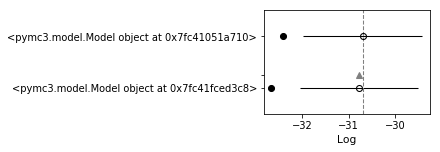

In [34]:
pm.compareplot(df_comp_WAIC);
plt.show()

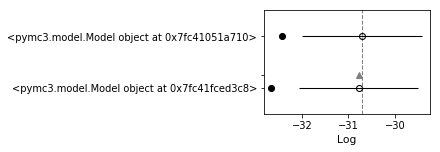

In [35]:
pm.compareplot(df_comp_LOO);
plt.show()

# Numpyro

## Centered_eight

In [36]:
# Eight Schools example
def eight_schools_cen(J, sigma, y=None):
     mu = numpyro.sample('mu', dist.Normal(0, 5))
     tau = numpyro.sample('tau', dist.HalfCauchy(5))
     with numpyro.plate('J', J):
            theta = numpyro.sample('theta', dist.Normal(mu, tau))
            numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [37]:
nuts_kernel_cen = NUTS(eight_schools_cen, target_accept_prob=0.99)
mcmc_cen = MCMC(nuts_kernel_cen, num_warmup=2000, num_samples=2000, num_chains=4, chain_method='sequential', progress_bar=True,jit_model_args=False)
rng_key = random.PRNGKey(0)
mcmc_cen.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy', 'num_steps', 'diverging'))


sample: 100%|██████████| 4000/4000 [00:05<00:00, 777.58it/s, 31 steps of size 2.41e-02. acc. prob=1.00] 


In [38]:
mcmc_cen.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      3.91      3.28      3.87     -1.17      9.01    113.46      1.05
       tau      3.30      3.09      2.43      0.22      7.27    156.49      1.05
  theta[0]      5.54      5.50      4.91     -2.08     13.68    168.81      1.04
  theta[1]      4.39      4.56      4.22     -2.44     11.61    167.42      1.04
  theta[2]      3.57      4.95      3.65     -3.80     11.65    492.16      1.02
  theta[3]      4.28      4.73      4.08     -2.85     11.71    236.66      1.03
  theta[4]      3.24      4.42      3.29     -3.46     10.47    387.71      1.02
  theta[5]      3.57      4.69      3.54     -3.39     11.29    374.09      1.02
  theta[6]      5.62      5.16      5.13     -1.82     13.37    143.03      1.04
  theta[7]      4.32      5.04      4.12     -3.37     12.27    265.20      1.03

Number of divergences: 391


In [39]:
pe = mcmc_cen.get_extra_fields()['potential_energy']

In [40]:
print('Expected log joint density: {:.2f}'.format(np.mean(-pe))) 

Expected log joint density: -52.11


In [41]:
print("There were {} transitions that exceeded the maximum treedepth.".format(
        (mcmc_cen.get_extra_fields()["num_steps"] + 1 == 2 ** 10).sum()))

There were 0 transitions that exceeded the maximum treedepth.


In [42]:
print("Number of divergences: {}".format(jnp.sum(mcmc_cen.get_extra_fields()["diverging"])))

Number of divergences: 391


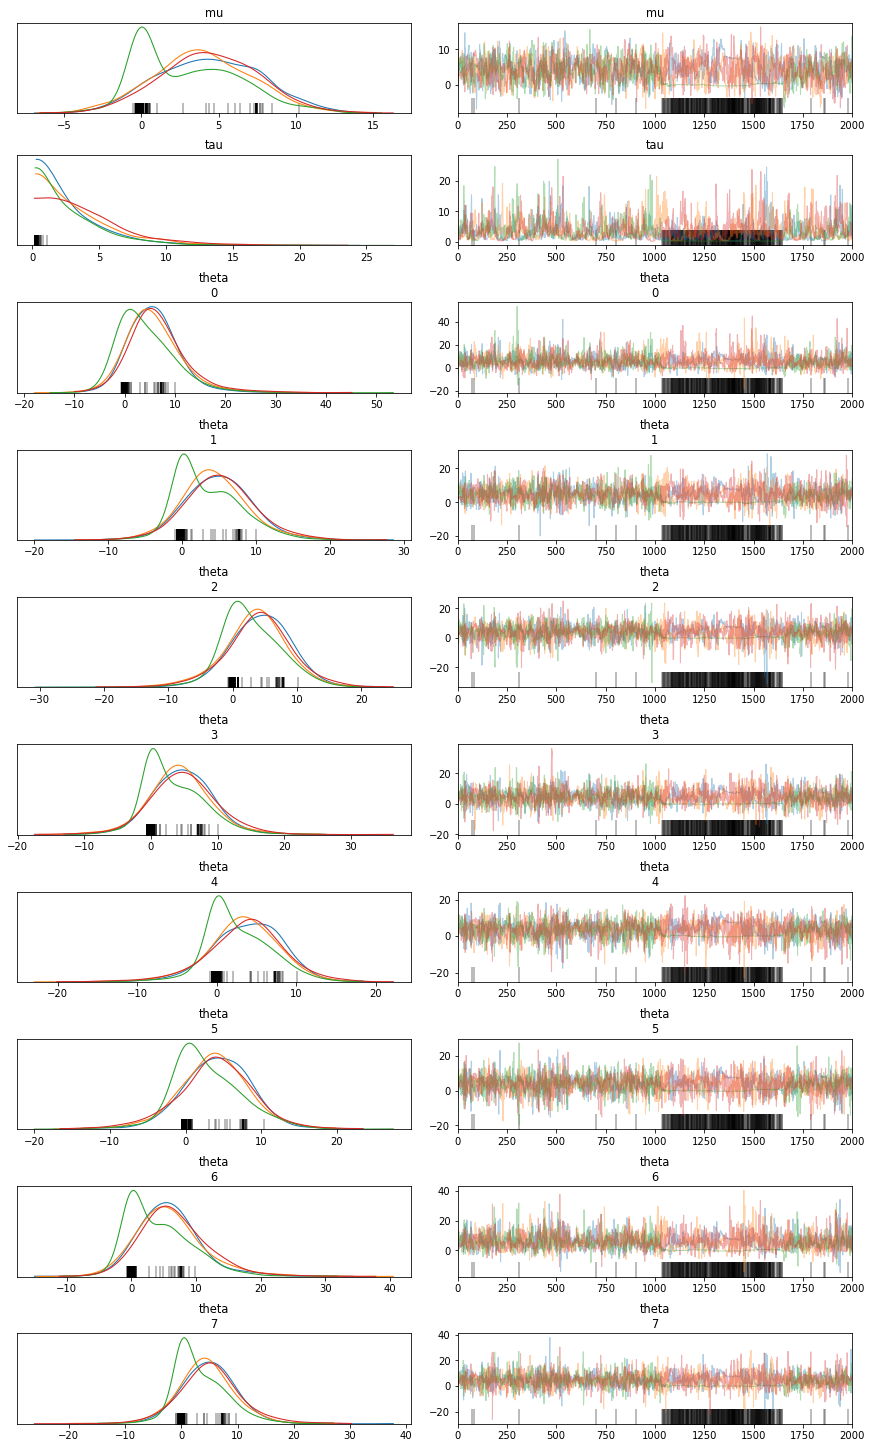

In [43]:
az.plot_trace(az.from_numpyro(mcmc_cen))
plt.show()

In [44]:
samples_cen = mcmc_cen.get_samples(group_by_chain=True)

In [45]:
np.log(samples_cen['tau']).shape

(4, 2000)

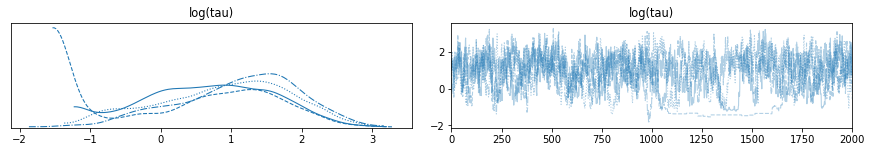

In [46]:
pm.traceplot({"log(tau)": np.log(samples_cen['tau'])});
plt.show()

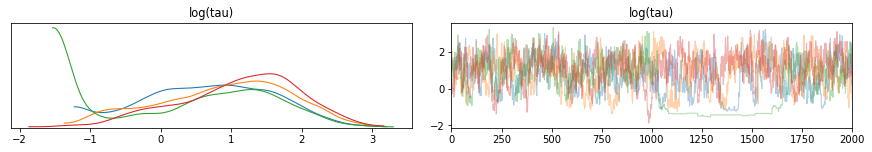

In [47]:
az.plot_trace({"log(tau)": np.log(samples_cen['tau'])})

plt.show()

In [48]:
#samples_cen

In [49]:
numpyro.diagnostics.summary(samples_cen)

{'mu': OrderedDict([('mean', 3.9096382),
              ('std', 3.283342),
              ('median', 3.8675299),
              ('5.0%', -1.1747541),
              ('95.0%', 9.006615),
              ('n_eff', 113.46327964609364),
              ('r_hat', 1.0510702033654002)]),
 'tau': OrderedDict([('mean', 3.302504),
              ('std', 3.094495),
              ('median', 2.434124),
              ('5.0%', 0.21560952),
              ('95.0%', 7.2701554),
              ('n_eff', 156.48924590442303),
              ('r_hat', 1.051770522975437)]),
 'theta': OrderedDict([('mean',
               array([5.5385413, 4.3922153, 3.5725594, 4.2791176, 3.2392623, 3.5717013,
                      5.619035 , 4.3150687], dtype=float32)),
              ('std',
               array([5.497466 , 4.5557957, 4.9481587, 4.729253 , 4.4232407, 4.688564 ,
                      5.162387 , 5.0432463], dtype=float32)),
              ('median',
               array([4.912636 , 4.2163267, 3.646228 , 4.082898 , 3.286583

In [50]:
numpyro.diagnostics.print_summary(samples_cen)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      3.91      3.28      3.87     -1.17      9.01    113.46      1.05
       tau      3.30      3.09      2.43      0.22      7.27    156.49      1.05
  theta[0]      5.54      5.50      4.91     -2.08     13.68    168.81      1.04
  theta[1]      4.39      4.56      4.22     -2.44     11.61    167.42      1.04
  theta[2]      3.57      4.95      3.65     -3.80     11.65    492.16      1.02
  theta[3]      4.28      4.73      4.08     -2.85     11.71    236.66      1.03
  theta[4]      3.24      4.42      3.29     -3.46     10.47    387.71      1.02
  theta[5]      3.57      4.69      3.54     -3.39     11.29    374.09      1.02
  theta[6]      5.62      5.16      5.13     -1.82     13.37    143.03      1.04
  theta[7]      4.32      5.04      4.12     -3.37     12.27    265.20      1.03



In [51]:
samples_cen['tau'].shape

(4, 2000)

In [52]:
numpyro.diagnostics.hpdi(samples_cen['tau'])

array([[1.2839551 , 1.6956928 , 0.88353586, ..., 1.2856464 , 0.87696856,
        0.5642191 ],
       [4.99699   , 3.8264515 , 5.0063233 , ..., 4.8064127 , 3.7754195 ,
        6.7522516 ]], dtype=float32)

In [53]:
numpyro.diagnostics.gelman_rubin(samples_cen['tau'])

1.0236697

In [54]:
numpyro.diagnostics.split_gelman_rubin(samples_cen['tau'])

1.051770522975437

In [55]:
numpyro.diagnostics.print_summary(samples_cen['tau'])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      3.30      3.09      2.43      0.22      7.27    156.49      1.05



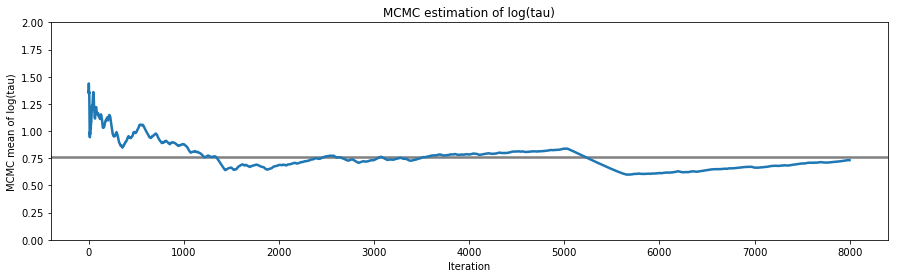

In [56]:
logtau = np.log(samples_cen['tau']).flatten()
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');
plt.show()

## NonCentered_eight

In [57]:
from numpyro.infer.reparam import TransformReparam

In [58]:
# Eight Schools example - Non-centered Reparametrization
def eight_schools_noncentered(J, sigma, y=None):
     mu = numpyro.sample('mu', dist.Normal(0, 5))
     tau = numpyro.sample('tau', dist.HalfCauchy(5))
     with numpyro.plate('J', J):
        with numpyro.handlers.reparam(config={'theta': TransformReparam()}):
             theta = numpyro.sample('theta', dist.TransformedDistribution(dist.Normal(0., 1.),
                                             dist.transforms.AffineTransform(mu, tau)))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [59]:
nuts_kernel_noncen = NUTS(eight_schools_noncentered, target_accept_prob=0.99)
mcmc_noncen = MCMC(nuts_kernel_noncen, num_warmup=2000, num_samples=2000, num_chains=4, chain_method='sequential', progress_bar=True,jit_model_args=False)
rng_key = random.PRNGKey(0)
mcmc_noncen.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy', 'num_steps', 'diverging'))


sample: 100%|██████████| 4000/4000 [00:05<00:00, 723.82it/s, 31 steps of size 1.74e-01. acc. prob=0.99]


In [60]:
mcmc_noncen.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.30      3.29      4.29     -1.00      9.85   6938.74      1.00
          tau      3.68      3.29      2.81      0.00      7.96   5262.19      1.00
theta_base[0]      0.33      0.98      0.34     -1.24      1.99   7491.87      1.00
theta_base[1]      0.10      0.92      0.11     -1.46      1.57   7270.71      1.00
theta_base[2]     -0.09      0.96     -0.10     -1.63      1.50   8391.95      1.00
theta_base[3]      0.07      0.94      0.08     -1.52      1.57   8004.55      1.00
theta_base[4]     -0.17      0.94     -0.17     -1.77      1.34   7735.09      1.00
theta_base[5]     -0.07      0.94     -0.07     -1.62      1.50   8101.46      1.00
theta_base[6]      0.36      0.96      0.38     -1.21      1.92   6605.93      1.00
theta_base[7]      0.06      0.98      0.05     -1.51      1.66   7779.43      1.00

Number of divergences: 0


In [61]:
pe = mcmc_noncen.get_extra_fields()['potential_energy']

In [62]:
print('Expected log joint density: {:.2f}'.format(np.mean(-pe))) 

Expected log joint density: -46.14


In [63]:
print("There were {} transitions that exceeded the maximum treedepth.".format(
        (mcmc_noncen.get_extra_fields()["num_steps"] + 1 == 2 ** 10).sum()))

There were 0 transitions that exceeded the maximum treedepth.


In [64]:
print("Number of divergences: {}".format(jnp.sum(mcmc_noncen.get_extra_fields()["diverging"])))


Number of divergences: 0


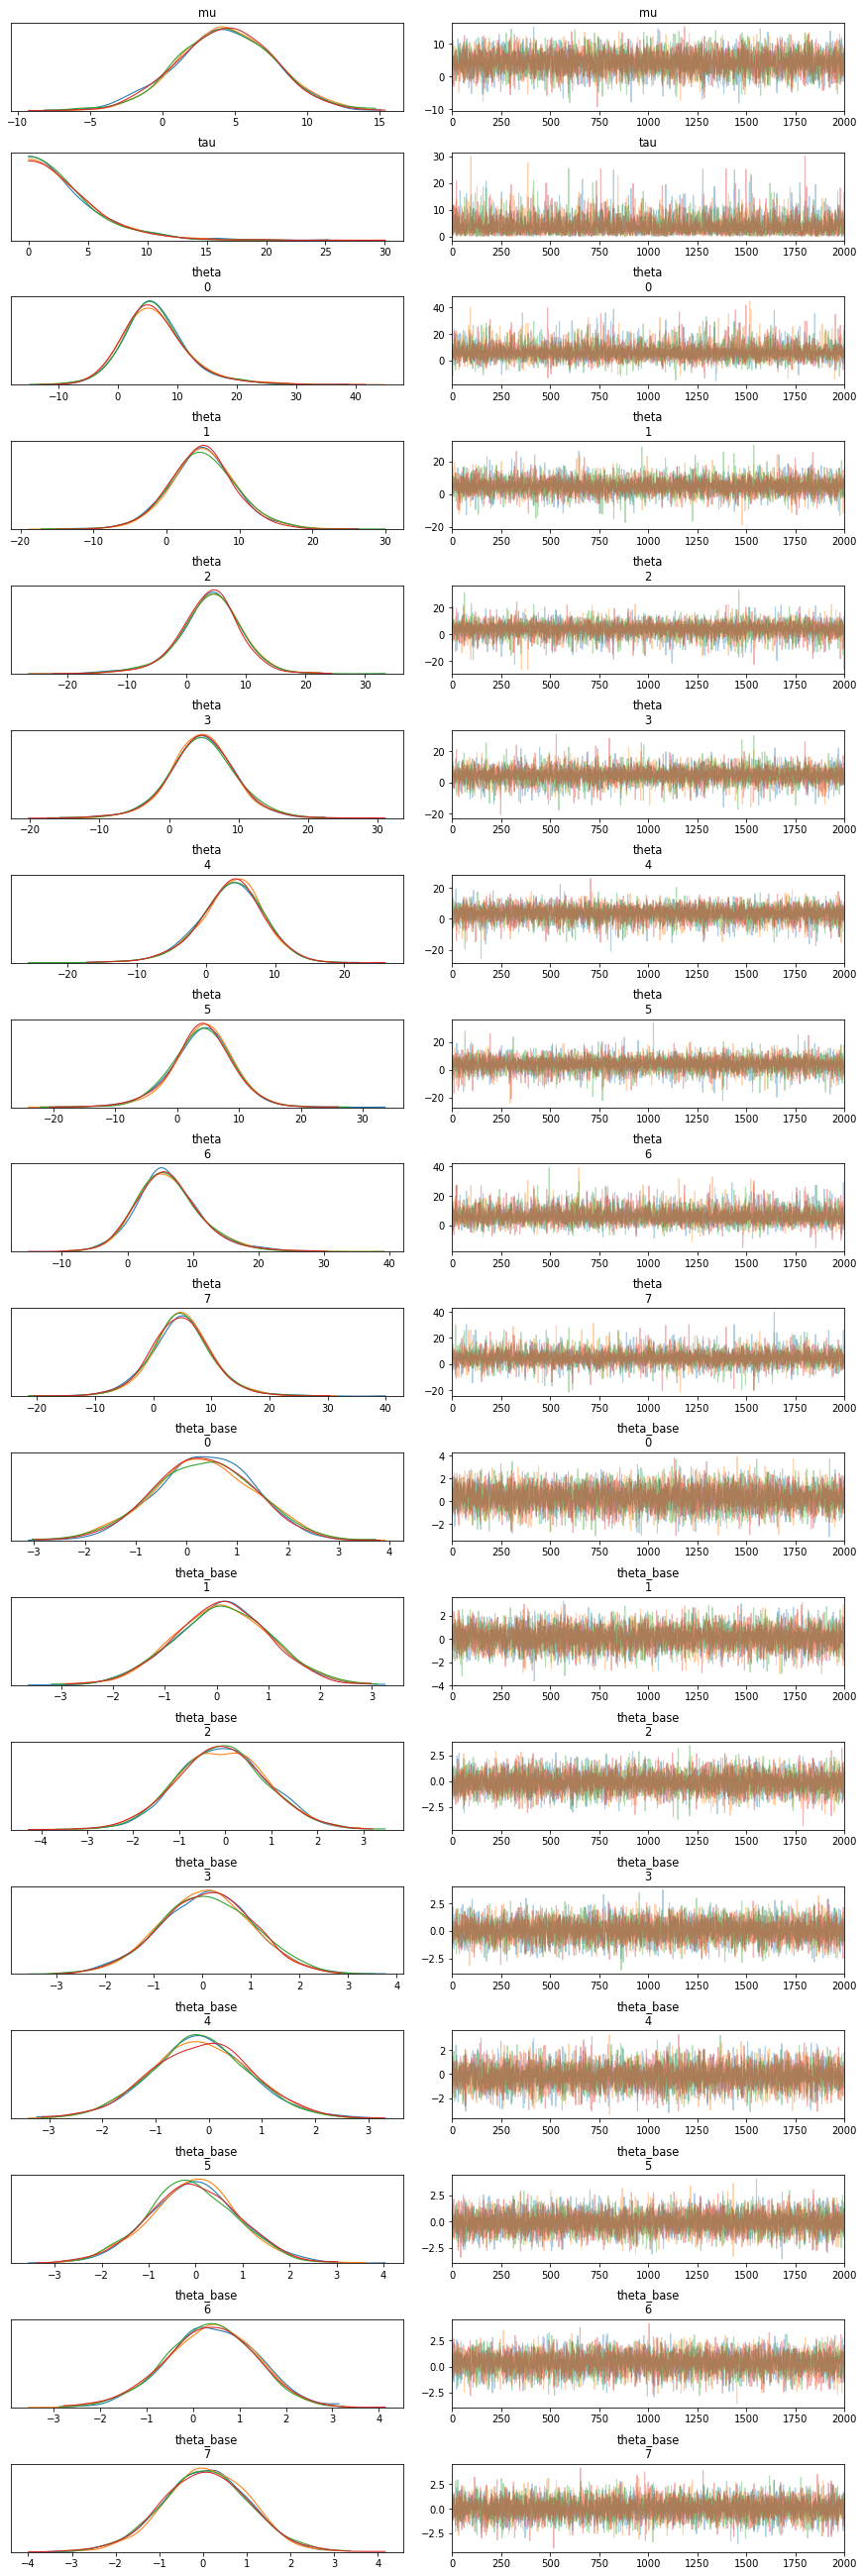

In [65]:
az.plot_trace(az.from_numpyro(mcmc_noncen))
plt.show()

In [66]:
samples_noncen = mcmc_noncen.get_samples(group_by_chain=True)

In [67]:
np.log(samples_noncen['tau']).shape

(4, 2000)

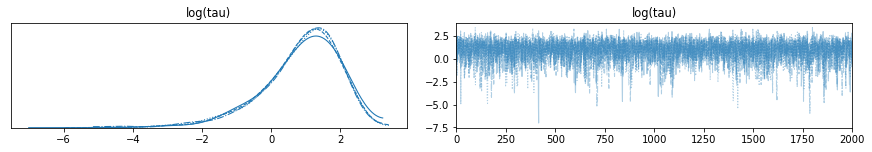

In [68]:
pm.traceplot({"log(tau)": np.log(samples_noncen['tau'])});
plt.show()

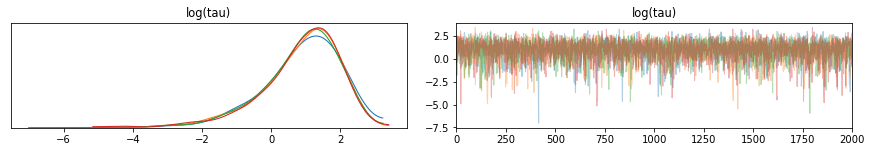

In [69]:
az.plot_trace({"log(tau)": np.log(samples_noncen['tau'])})

plt.show()

In [70]:
#samples_noncen

In [71]:
numpyro.diagnostics.summary(samples_noncen)

{'mu': OrderedDict([('mean', 4.2998977),
              ('std', 3.292938),
              ('median', 4.289836),
              ('5.0%', -1.0042908),
              ('95.0%', 9.850126),
              ('n_eff', 6938.738851910012),
              ('r_hat', 1.0001683814992466)]),
 'tau': OrderedDict([('mean', 3.6757956),
              ('std', 3.2891479),
              ('median', 2.8062408),
              ('5.0%', 0.0042752745),
              ('95.0%', 7.961122),
              ('n_eff', 5262.18601900393),
              ('r_hat', 1.000650131244605)]),
 'theta': OrderedDict([('mean',
               array([6.251415 , 4.9194374, 3.8260922, 4.67929  , 3.5210238, 3.9443243,
                      6.279302 , 4.7824054], dtype=float32)),
              ('std',
               array([5.682309 , 4.606941 , 5.202408 , 4.7715707, 4.6824374, 4.8538184,
                      5.0671554, 5.3218045], dtype=float32)),
              ('median',
               array([5.638177 , 4.8526435, 4.12432  , 4.6838856, 3.820168

In [72]:
numpyro.diagnostics.print_summary(samples_noncen)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.30      3.29      4.29     -1.00      9.85   6938.74      1.00
          tau      3.68      3.29      2.81      0.00      7.96   5262.19      1.00
     theta[0]      6.25      5.68      5.64     -2.36     14.98   7882.88      1.00
     theta[1]      4.92      4.61      4.85     -2.81     12.05   8769.68      1.00
     theta[2]      3.83      5.20      4.12     -4.14     12.36   8119.24      1.00
     theta[3]      4.68      4.77      4.68     -2.89     12.42   7944.82      1.00
     theta[4]      3.52      4.68      3.82     -3.92     11.10   8427.37      1.00
     theta[5]      3.94      4.85      4.13     -3.75     11.91   9108.78      1.00
     theta[6]      6.28      5.07      5.76     -1.88     14.06   7995.21      1.00
     theta[7]      4.78      5.32      4.68     -3.93     12.99   7831.22      1.00
theta_base[0]      0.33      0.98      0.34     -1.24      1.99   7491.87  

In [73]:
samples_noncen['tau'].shape

(4, 2000)

In [74]:
numpyro.diagnostics.hpdi(samples_noncen['tau'])

array([[ 0.52325857,  1.446865  ,  2.943437  , ...,  1.1759441 ,
         1.0802354 ,  0.33311692],
       [ 9.658116  , 10.614082  ,  6.9296827 , ..., 16.486525  ,
         9.058676  ,  6.6725206 ]], dtype=float32)

In [75]:
numpyro.diagnostics.gelman_rubin(samples_noncen['tau'])

1.0001827

In [76]:
numpyro.diagnostics.split_gelman_rubin(samples_noncen['tau'])

1.000650131244605

In [77]:
numpyro.diagnostics.print_summary(samples_noncen['tau'])


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      3.68      3.29      2.81      0.00      7.96   5262.19      1.00



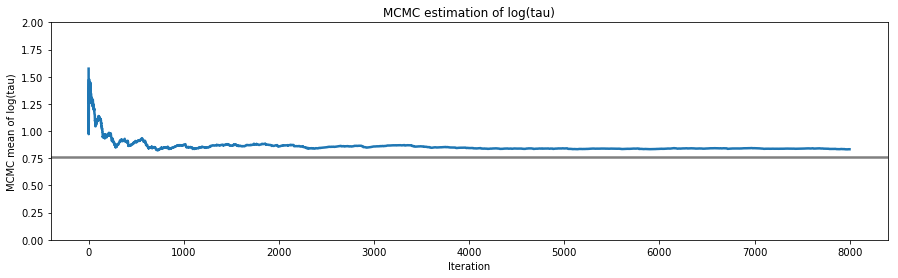

In [78]:
logtau = np.log(samples_noncen['tau']).flatten()
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');
plt.show()

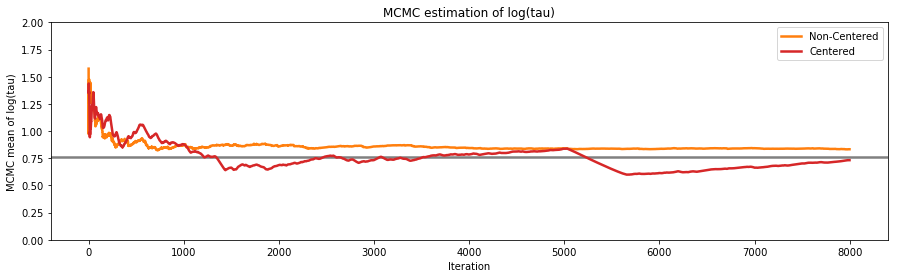

In [79]:
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')


logtau_noncen = np.log(samples_noncen['tau']).flatten()
mlogtau_noncen = [np.mean(logtau_noncen[:i]) for i in np.arange(1, len(logtau_noncen))]
plt.plot(mlogtau_noncen, color='C1', lw=2.5, label='Non-Centered')

logtau_cen = np.log(samples_cen['tau']).flatten()
mlogtau_cen = [np.mean(logtau_cen[:i]) for i in np.arange(1, len(logtau_cen))]

plt.plot(mlogtau_cen, color='C3', lw=2.5, label='Centered')


plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend();
plt.show()

In [80]:
from numpyro.infer import Predictive

In [81]:
# New School
def new_school():
     mu = numpyro.sample('mu', dist.Normal(0, 5))
     tau = numpyro.sample('tau', dist.HalfCauchy(5))
     return numpyro.sample('obs', dist.Normal(mu, tau))

In [82]:
predictive = Predictive(new_school, mcmc_cen.get_samples())
samples_predictive = predictive(random.PRNGKey(1))
print(np.mean(samples_predictive['obs']))  

3.9939463


In [83]:
predictive = Predictive(new_school, mcmc_noncen.get_samples())
samples_predictive = predictive(random.PRNGKey(1))
print(np.mean(samples_predictive['obs'])) 

4.4010224
